This is how you import the class

In [1]:
from cats.pawprint.pawprint import Pawprint

importing other stuff for this notebook

In [2]:
import numpy as np
import galstreams as gst
from astropy.coordinates import SkyCoord
import astropy.units as u
from matplotlib import pyplot as plt

load a pawprint from galstreams (creates a sky footprint for the stream and background from the track, leaves others blank)

In [3]:
p = Pawprint.from_galstreams('Jhelum-a','bonaca2019')

Generate random points on the sphere in an area around the track

In [4]:
rao,raf = np.min(p.track.track.ra.deg), np.max(p.track.track.ra.deg)
deco,decf = np.min(p.track.track.dec.deg),np.max(p.track.track.dec.deg)
field_ra, field_dec = gst.get_random_spherical_angles(5000,az=[rao,raf],
                                                           lat=[deco,decf],degree=True)
field = SkyCoord(ra=field_ra*u.deg, dec=field_dec*u.deg, frame='icrs')

generate masks for the on- and off-stream sky footprints

In [6]:
on = p.skyprint['stream'].inside_footprint(field)
off = p.skyprint['background'].inside_footprint(field)

plot things in equatorial coordinates

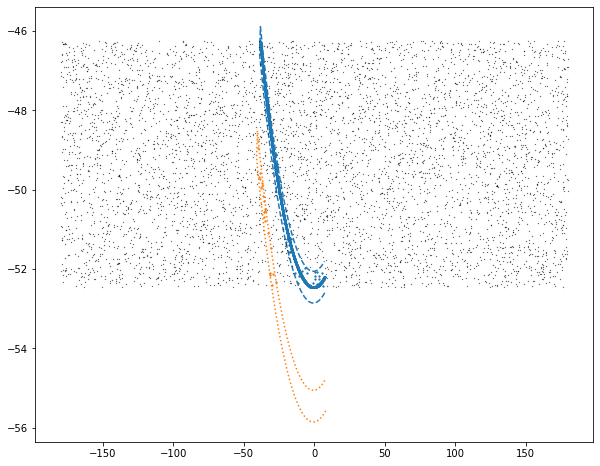

In [7]:

plt.figure(1,figsize=(10,8))
ax = plt.subplot(111)

#plot the track
ax.plot(p.track.track.ra.wrap_at(180*u.deg), p.track.track.dec, '.', ms=2., color='C0')

#plot the on-stream polygon
ax.plot(p.skyprint['stream'].edges.icrs.ra.wrap_at(180*u.deg), p.skyprint['stream'].edges.icrs.dec, ls='--', color='C0')

#plot random background "field" points 
ax.plot(field.ra.wrap_at(180*u.deg), field.dec, 'k.', ms=0.5)

#plot the field points inside the polygon footprint
ax.plot(field.ra[on].wrap_at(180*u.deg), field.dec[on], '.', ms=2.5, color='C0')

#Plot the off-stream polygon footprint and points selected inside it
ax.plot(p.skyprint['background'].edges.icrs.ra.wrap_at(180*u.deg), p.skyprint['background'].edges.icrs.dec, ls=':', color='C1')
ax.plot(field.ra[off].wrap_at(180*u.deg), field.dec[off], '.', ms=2.5, color='C1')

plot things in stream coordinates

(-10.0, 10.0)

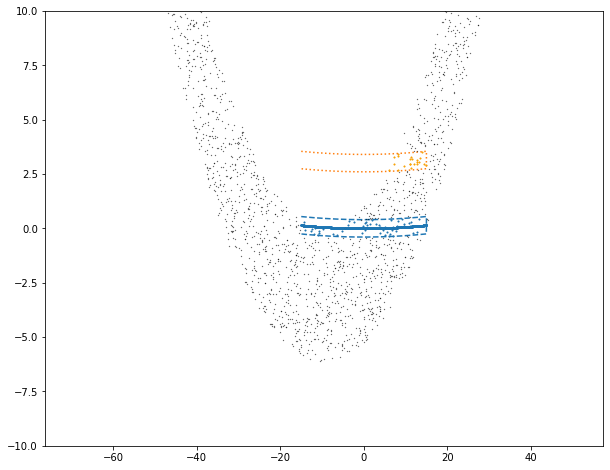

In [8]:

plt.figure(1,figsize=(10,8))
ax = plt.subplot(111)

#Plot the track in phi1/phi2
ax.plot(p.track.track.transform_to(p.stream_frame).phi1, 
        p.track.track.transform_to(p.stream_frame).phi2, '.', ms=2., color='C0')
#plot the on-stream polygon 
ax.plot(p.skyprint['stream'].edges.transform_to(p.stream_frame).phi1, 
        p.skyprint['stream'].edges.transform_to(p.stream_frame).phi2, ls='--', color='C0')
#plot the off-stream polygon
ax.plot(p.skyprint['background'].edges.transform_to(p.stream_frame).phi1, 
        p.skyprint['background'].edges.transform_to(p.stream_frame).phi2, ls=':', color='C1')

ax.plot(field.transform_to(p.stream_frame).phi1, field.transform_to(p.stream_frame).phi2,'.k', ms=0.5)
ax.plot(field[on].transform_to(p.stream_frame).phi1, field[on].transform_to(p.stream_frame).phi2,'.', ms=2)
ax.plot(field[off].transform_to(p.stream_frame).phi1, field[off].transform_to(p.stream_frame).phi2,'.', color='orange', ms=2)

ax.set_ylim(-10,10)

In [5]:
from cats.pawprint.pawprint import Footprint2D

In [6]:
f_new_cmd = Footprint2D.from_box(-0.3,0.3,-0.3,0.3,footprint_type='cartesian')

In [7]:
p.add_cmd_footprint(f_new_cmd,'g_r','i_z','BHB_color_color')

In [8]:
p.cmdprint['BHB_color_color'].edges

[[-0.3, -0.3], [-0.3, 0.3], [0.3, -0.3], [0.3, 0.3]]

In [10]:
p.cmdprint['BHB_color_color'].footprint_type

'cartesian'

save the pawprint (you will get a warning about it not knowing how to save the stream frame....)

In [11]:
p.save_pawprint()

/opt/anaconda3/envs/cats/lib/python3.8/site-packages/asdf/schema.py:301: AsdfWarning: Unable to locate schema file for 'tag:astropy.org:astropy/coordinates/frames/greatcircleicrsframe-1.0.0': 'http://astropy.org/schemas/astropy/coordinates/frames/greatcircleicrsframe-1.0.0'
  warnings.warn(msg.format(tag, schema_uri), AsdfWarning)


if you want to inspect the pawprint directly you can load it with asdf or astropy's asdf reader.
 (again, you will get a warning about it not knowing how to save the stream frame....)

In [12]:
import asdf
a = asdf.open('Jhelum-a.bonaca2019.asdf')

/opt/anaconda3/envs/cats/lib/python3.8/site-packages/asdf/yamlutil.py:300: AsdfConversionWarning: tag:astropy.org:astropy/coordinates/frames/greatcircleicrsframe-1.0.0 is not recognized, converting to raw Python data structure
  warnings.warn(


all the bits are in a dictionary

In [13]:
print(a.keys())

dict_keys(['asdf_library', 'history', 'cmd_filters', 'off_stream', 'on_stream', 'pawprint_ID', 'stream_frame', 'stream_name', 'width'])


In [14]:
a['stream_name']

'Jhelum-a'

In [15]:
a['on_stream']['sky']['vertices'][:]

array([[-14.99929874,   0.54219946],
       [-14.98929585,   0.54201078],
       [-14.97929296,   0.54182223],
       ...,
       [-14.97929296,  -0.25817777],
       [-14.98929585,  -0.25798922],
       [-14.99929874,  -0.25780054]])

In [16]:
a['off_stream']['vertices'][:]

array([[-14.99929874,   3.54219946],
       [-14.98929585,   3.54201078],
       [-14.97929296,   3.54182223],
       ...,
       [-14.97929296,   2.74182223],
       [-14.98929585,   2.74201078],
       [-14.99929874,   2.74219946]])

here is the footprint we added:

In [17]:
a['on_stream']['cmd']

{'BHB_color_color': {'footprint_type': 'cartesian',
  'stream_frame': None,
  'vertices': [[-0.3, -0.3], [-0.3, 0.3], [0.3, -0.3], [0.3, 0.3]]}}

In [19]:
print(a['cmd_filters'])

{'BHB_color_color': ['g_r', 'i_z']}


but currently no PM footprints:

In [20]:
a['on_stream']['pm']

we are currently working on getting the loading from file to work:

In [21]:
p2 = Pawprint.from_file('Jhelum-a.bonaca2019.asdf')

ValueError: Coordinate frame must be a frame name or frame class, not a 'TaggedDict'